In [2]:
%pip install pandas numpy seaborn matplotlib scikit-learn sentence-transformers

Note: you may need to restart the kernel to use updated packages.


### Importing Libraries ###

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sentence_transformers import SentenceTransformer
from preprocessing import clean_data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

### Loading & Inspecting Data ###


In [4]:
# Loading Data
delta_df = pd.read_csv("datasets/Delta_Airline_Review_Dataset-Asof02172023.csv")
display(delta_df.head())

# Inspecting Data
print("----Data Info----\n")
print(delta_df.info())

print("\n----Data Shape----\n")
print(f'delta_df.shape: {delta_df.shape}')

print("\n----Data Stats----\n")
print(delta_df.describe())

print("\n----Data Null----\n")
print(delta_df.isnull().sum())


----Data Info----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer_ID     2689 non-null   int64 
 1   star rating     2689 non-null   int64 
 2   date            2689 non-null   object
 3    Seat Type      2689 non-null   object
 4   routes          2263 non-null   object
 5   traveler_types  2282 non-null   object
 6   country         2689 non-null   object
 7   reviews         2689 non-null   object
dtypes: int64(2), object(6)
memory usage: 168.2+ KB
None

----Data Shape----

delta_df.shape: (2689, 8)

----Data Stats----

       Customer_ID  star rating
count  2689.000000  2689.000000
mean   1345.000000     3.860915
std     776.391761     3.462060
min       1.000000     0.000000
25%     673.000000     1.000000
50%    1345.000000     2.000000
75%    2017.000000     8.000000
max    2689.000000    10.000000

----Data Null----

Cu

### Cleaning Data ###

In [12]:
cleaned_delta_df = clean_data(delta_df)
print(f'cleaned_delta_df.shape: {cleaned_delta_df.shape}')
display(cleaned_delta_df.head())

----Data Cleaned----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Customer_ID     2689 non-null   int64         
 1   star rating     2689 non-null   int64         
 2   date            2689 non-null   datetime64[ns]
 3    Seat Type      2689 non-null   object        
 4   routes          2689 non-null   object        
 5   traveler_types  2689 non-null   object        
 6   country         2689 non-null   object        
 7   reviews         2689 non-null   object        
 8   sentiment       2689 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(5)
memory usage: 170.9+ KB
None

Null values:
 Customer_ID       0
star rating       0
date              0
 Seat Type        0
routes            0
traveler_types    0
country           0
reviews           0
sentiment         0
dtype: int64

Se

,Customer_ID,star rating,date,Seat Type,routes,traveler_types,country,reviews,sentiment
0,1,4,2023-02-17,economy class,new york to tel aviv,solo leisure,united states,"first, travel starts 6pm arrival at the air...",Positive
1,2,1,2023-02-16,economy class,milwaukee to ft lauderdale,business,united states,delta did not issue any weather waivers so ...,Negative
2,3,1,2023-02-10,economy class,new york to charlotte,business,united states,"per our pilot, there would be a slight dela...",Negative
3,4,1,2023-02-08,premium economy,atlanta to cape town,family leisure,united states,we flew from atlanta to cape town and back ...,Negative
4,5,2,2023-02-06,economy class,dallas to atlanta,solo leisure,united kingdom,"checkin staff always seem unfriendly, no ma...",Negative


### Preliminary Visualization ###

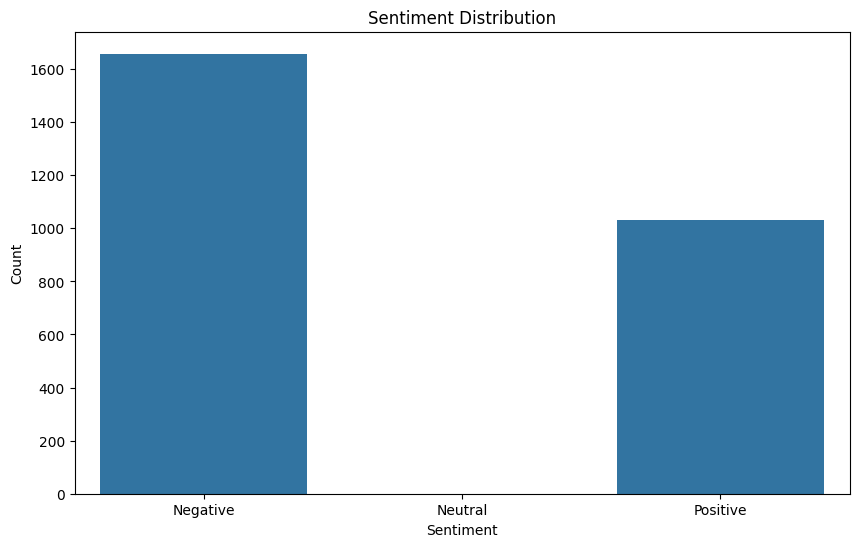

In [7]:
# Data description distribution
plt.figure(figsize=(10, 6))

plt.pie(cleaned_delta_df['sentiment'].value_counts(), autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


### Preprocessing Data ###

In [8]:
def tokenize_text(text):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(text)
    return embeddings

cleaned_delta_df['embedding'] = cleaned_delta_df['reviews'].apply(tokenize_text)

### Model Training ###

In [9]:
# Features and target
X = np.array(cleaned_delta_df['embedding'].tolist())
y = cleaned_delta_df['sentiment'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}")

Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.92      0.74       331
    Positive       0.42      0.09      0.14       207

    accuracy                           0.60       538
   macro avg       0.52      0.51      0.44       538
weighted avg       0.54      0.60      0.51       538



### Visualizing Model ###

In [16]:
def plot_feature_importance(model, n_features=10, figsize=(10,6)):
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot top n_features
    plt.figure(figsize=figsize)
    plt.title('Top Feature Importances in Sentiment Analysis')
    
    # Plot only top n_features
    n = min(n_features, len(importances))
    plt.bar(range(n), 
            importances[indices][:n],
            align='center')
    
    # Use feature indices as labels
    plt.xticks(range(n), 
               [f'Feature {i}' for i in indices[:n]], 
               rotation=45,
               ha='right')
    
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()

def plot_decision_tree(model, max_depth=3, figsize=(20,10)):
    plt.figure(figsize=figsize)
    # Get a single tree from the forest
    tree = model.estimators_[0]
    
    # Create feature names for all dimensions
    feature_names = [f'dim_{i}' for i in range(model.n_features_in_)]
    
    plot_tree(tree, 
             feature_names=feature_names,
             max_depth=max_depth,
             filled=True,
             rounded=True)
    plt.show()

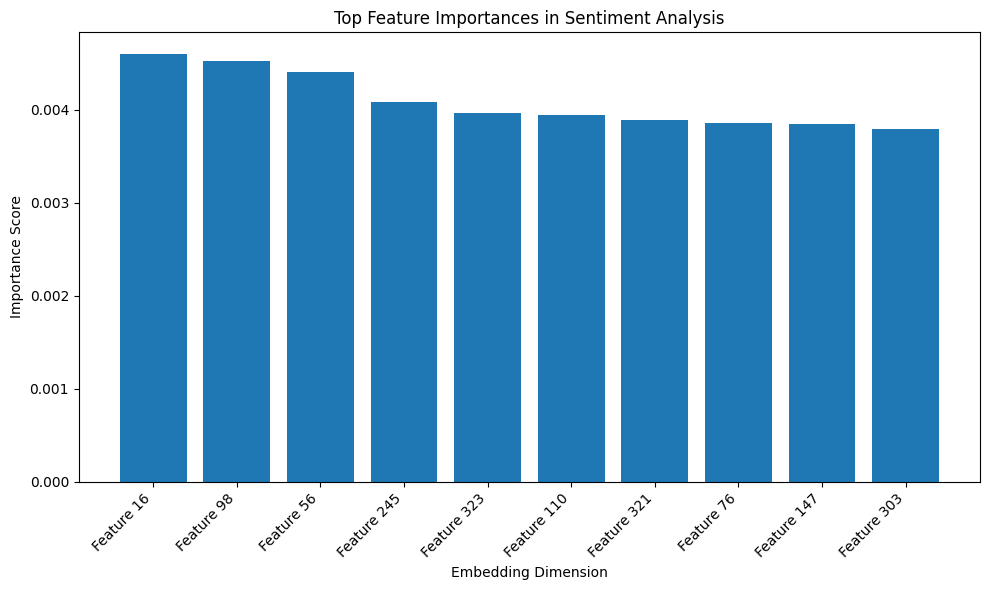

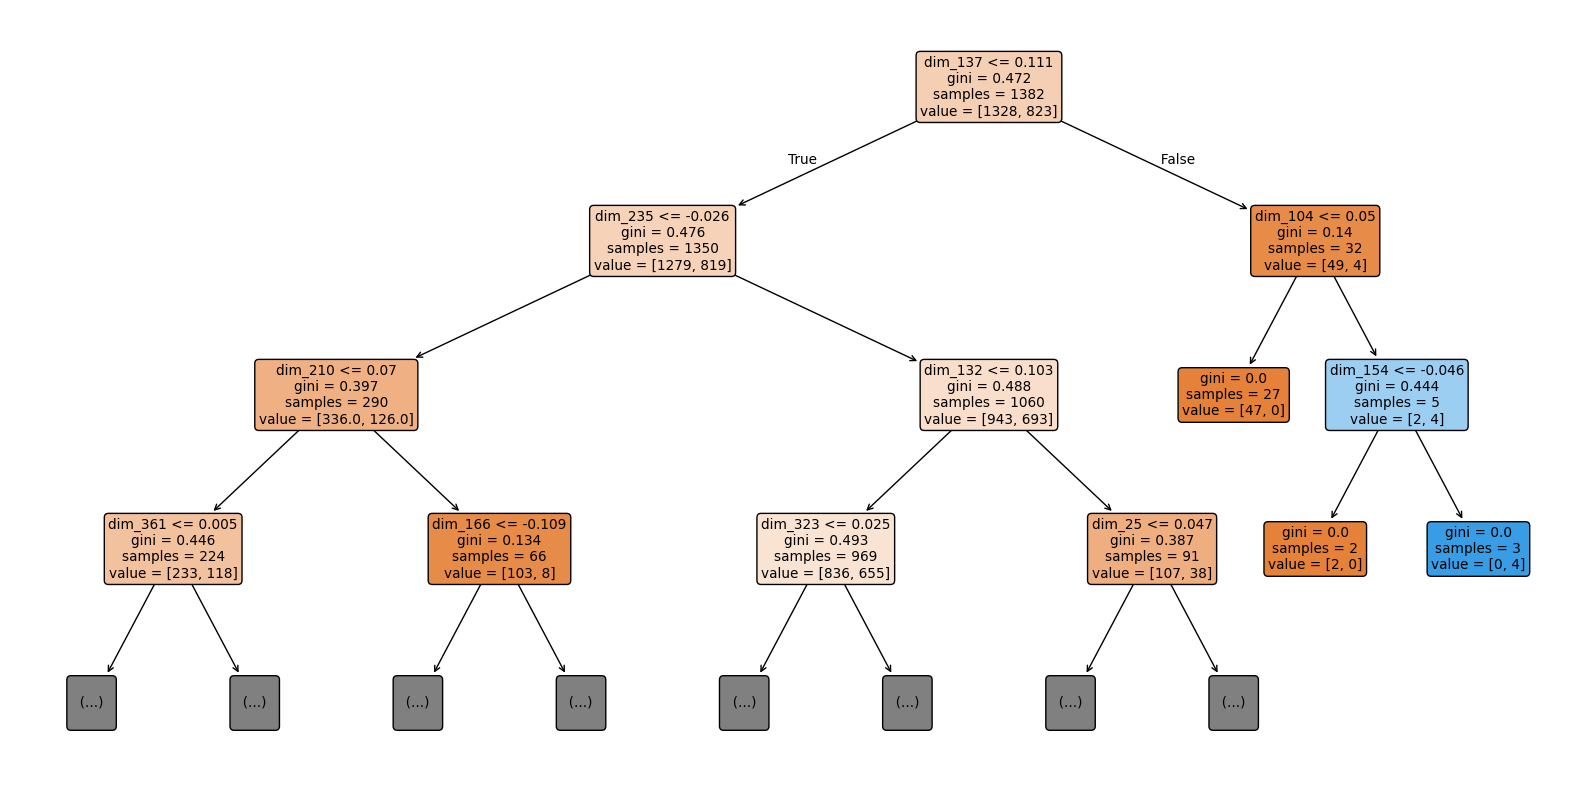

In [17]:
# Visualize feature importance (top 10 features)
plot_feature_importance(
    model=model,
    n_features=10
)

# Visualize a single tree from the forest
plot_decision_tree(
    model=model,
    max_depth=3
)